# **Okay so:**
The bit after the rainbow is where the useful stuff begins: it will go through all the shapefiles, pick out random points, get the label for that point etc., and create the subsamples.
Make sure you change the directory to what YOU named them

### Dataset preparation - (1) sub-sampling

Sample patches from each TIF image, and find the corresponding label using the Shapefiles. Save each image with a unique ID save in the directory **SAMPLING_DIR**. Save the corresponding meta data in the following format (this could be a CSV file, NumPy array, or some other format), in the directory **META_DIR**:


```
image_id, x, y, label
```

Set the label value as one of "L", "W", "I" as specified in the Shapefiles.

To make it easier to patch the final segmentation back together, it is suggested to use the (x, y) pixel coordinates of the patch, rather than the spatial coordinates.

Mounting the drive n stuff

In [5]:
from google.colab import drive
drive.mount('/gdrive')
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Mounted at /gdrive
Mounted at /content/drive


In [222]:
SAMPLING_DIR = "/content/drive/sampling/"
META_DIR = "/content/drive/training/"

In [84]:
def draw_sample(fname):
  SHAPEFILE_DIR = "/content/drive/My Drive/bloop/EE_Polar_Training_Dataset_v-1-0-0/Sea_Ice/" 
  TIFF_DIR = "/content/drive/My Drive/bloop/Sentinel geotiffs"
  shapefile = SHAPEFILE_DIR + fname # full name of .shp file
  # extract the shape ID, for example, 20180116T075430
  shp_id = shapefile.split("_")[-1][:-4].upper()
  tiff_files = [g for g in glob.glob(TIFF_DIR+'/*.tif')]
  # locate the corresponding Sentinel-1 image based on the ID
  # this should only return 1 match, which you can confirm
  tiff_file = [g for g in tiff_files if shp_id in g]
  tiff_file = tiff_file[0]
  

In [6]:
import glob

Some helpful code: reading in a single Sentinel-1 image and the corresponding Shapefile.

In [7]:
# the directory containing all shapefiles - i.e., the location of sea_ice/ 
SHAPEFILE_DIR = "/content/drive/My Drive/bloop/EE_Polar_Training_Dataset_v-1-0-0/Sea_Ice/" 
TIFF_DIR = "/content/drive/My Drive/bloop/Sentinel geotiffs"

shapefile = SHAPEFILE_DIR + "seaice_s1_20180116t075430.shp" # full name of .shp file

# extract the shape ID, for example, 20180116T075430
shp_id = shapefile.split("_")[-1][:-4].upper()

tiff_files = [g for g in glob.glob(TIFF_DIR+'/*.tif')]
# locate the corresponding Sentinel-1 image based on the ID
# this should only return 1 match, which you can confirm
tiff_file = [g for g in tiff_files if shp_id in g]
tiff_file = tiff_file[0]

In [95]:
tiff_file

'/content/drive/My Drive/bloop/Sentinel geotiffs/S1A_EW_GRDM_1SDH_20180116T075430_20180116T075530_020177_0226B9_9FE3_Orb_Cal_Spk_TC_rgb_8bit.tif'

Feel free to use other Python packages; but as an example, here we use **geopandas** to read in the Shapefile, and **rasterio** to read the GeoTIFF.

In [9]:
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

E: Package 'python-software-properties' has no installation candidate


In [8]:
import gdal
array = gdal.Open(tiff_file).ReadAsArray()

In [97]:
array.shape

(3, 15218, 15564)

In [10]:
import geopandas as gpd
#import rasterio

shape_data = gpd.read_file(shapefile)

shape_data.head()

,id,CA,SA,FA,CB,SB,FB,CT,poly_type,area,perimeter,geometry
0,1,99,99,99,99,99,99,99,I,10797710,27049,"POLYGON ((-489524.300 -1426091.270, -488551.97..."
1,2,99,99,99,99,99,99,99,W,77404396626,2078665,"POLYGON ((-386420.098 -1661503.239, -386646.67..."
2,3,99,99,99,99,99,99,99,I,145176122,64674,"POLYGON ((-485920.665 -1506863.657, -483911.10..."
3,4,99,99,99,99,99,99,99,L,10137,572,"POLYGON ((-470402.672 -1412012.139, -470511.58..."
4,5,99,99,99,99,99,99,99,L,1284942354,277299,"POLYGON ((-503153.134 -1606829.784, -503172.44..."


In [169]:
np.sqrt((shape_data['area']).min())

128.51069994362337

In [100]:
(shape_data['poly_type']=='L').sum()

4

In [101]:
(shape_data['poly_type']=='I').sum()

179

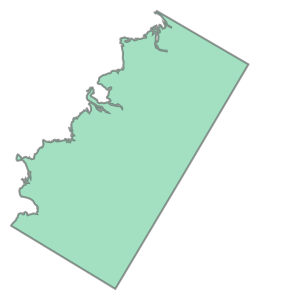

In [26]:
shape_data['geometry'][1]

In [43]:
array = gdal.Open(tiff_file)

In [44]:
dataset=array

print("Driver: {}/{}".format(dataset.GetDriver().ShortName,
                            dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize,
                                    dataset.RasterYSize,
                                    dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 15564 x 15218 x 3
Projection is PROJCS["Stereographic / World Geodetic System 1984|",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Stereographic"],PARAMETER["latitude_of_origin",90],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = (-641345.5143141792, -1225812.3968040443)
Pixel Size = (40.0, -40.0)


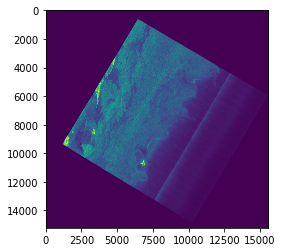

In [55]:
import matplotlib.pyplot as plt
band = dataset.GetRasterBand(1).ReadAsArray()
arr = band.ReadAsArray()
plt.imshow(arr)

In [59]:
maxx

-18785.514314179192

In [50]:
band = array.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=Byte
Min=1.000, Max=212.000
Band has 8 overviews


In [116]:
# Does not work so pls ignore lololol
# directory containing all GeoTIFF files

#tif_img = rasterio.open(TIFF_DIR + tiff_file)

The shapes in the Shapefiles are **shapely** objects. We can also use the Python package **shapely** to check whether an x, y pixel coordinate position is in a given polyshape.

In [24]:
from shapely.geometry import Point

x = -214683.0164737697
y = -1599535.861627199

point = Point(x, y)

# for example, specify the shape in the Shapefile
shape_id = 1

if shape_data['geometry'][shape_id].contains(point):
    print("Point", point, "is in shape", shape_id, "and has class", shape_data['poly_type'][shape_id])

Point POINT (-214683.0164737697 -1599535.861627199) is in shape 1 and has class W


In [62]:
import numpy as np

In [178]:
(maxx-minx)/width

40.0

(-520419.14351420297, 40.0, 0.0, -1263191.971308094, 0.0, -40.0)

In [79]:
ds = dataset
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

pointspermonth = 20

xs = np.random.uniform(minx, maxx, 20)
ys = np.random.uniform(miny, maxy, 20)

In [85]:
def getclass():
  while True:
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    point = Point(x,y)
    for i, shape in enumerate(shape_data):
      if shape_data['geometry'][i].contains(point):
        return shape_data['poly_type'][i], x, y


In [104]:
#for i in range(100):
#  print(getclass())
SAMPLING_DIR = "/content/drive/sampling"
META_DIR = "/content/drive/training"

In [80]:
# the directory containing all shapefiles - i.e., the location of sea_ice/ 
SHAPEFILE_DIR = "/content/drive/My Drive/bloop/EE_Polar_Training_Dataset_v-1-0-0/Sea_Ice/" 
TIFF_DIR = "/content/drive/My Drive/bloop/Sentinel geotiffs"

shapefile = SHAPEFILE_DIR + "seaice_s1_20180116t075430.shp" # full name of .shp file

# extract the shape ID, for example, 20180116T075430
shp_id = shapefile.split("_")[-1][:-4].upper()

tiff_files = [g for g in glob.glob(TIFF_DIR+'/*.tif')]
# locate the corresponding Sentinel-1 image based on the ID
# this should only return 1 match, which you can confirm               
tiff_file = [g for g in tiff_files if shp_id in g]
tiff_file = tiff_file[0]

# This is where the cool stuff starts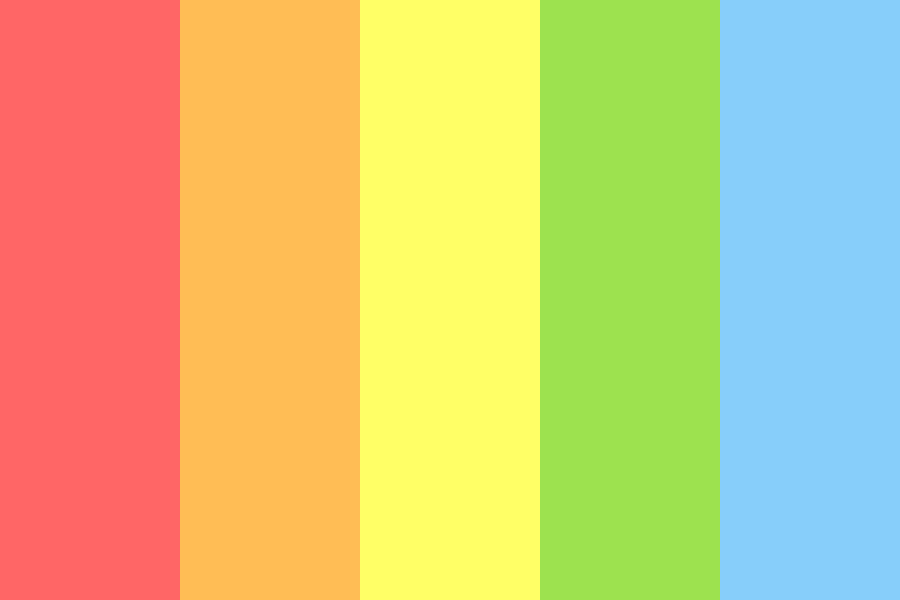

ppm = points per month - how many images we want from each .tif file



slicexdim, sliceydim: resolution of resulting image (I chose 128 because the square root of the size of the smallest area was around 129)

I'm not really sure how to save to a specific directory so this will just create the files to a random place, please change if you know how :)

Make sure your directories are defined!

You will have 1 .csv file with the file ID, classification, x and y for each image, and 12 * ppm images of size(slicexdim * sliceydim)

In [237]:
shapefilelist = [g for g in glob.glob(SHAPEFILE_DIR+'/*.shp')]
ppm = 1
slicexdim = 128
sliceydim = 128

outfile = np.empty((ppm*12,4),dtype=object)

def getclass(shape_data, minx, maxx, miny, maxy):
  while True:
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    point = Point(x,y)
    for i in range(shape_data.shape[0]):
      if shape_data['geometry'][i].contains(point):
        return shape_data['poly_type'][i], x, y

def findslice(x, y, gt, slicexdim, sliceydim, width, height):
  minx = gt[0]
  miny = gt[3] + width*gt[4] + height*gt[5] 
  maxx = gt[0] + width*gt[1] + height*gt[2]
  maxy = gt[3]
  dx = (maxx-minx)/width
  dy = (maxy-miny)/height
  pointx = np.int((x-minx)/dx)
  pointy = np.int((y-miny)/dy)
  
  yrangemin = np.int(pointy-sliceydim/2)
  yrangemax = np.int(pointy+sliceydim/2)

  xrangemin = np.int(pointx-slicexdim/2)
  xrangemax = np.int(pointx+slicexdim/2)
  return xrangemin, xrangemax, yrangemin, yrangemax

for k, file in enumerate(shapefilelist):
  shapefile = file
  shp_id = shapefile.split("_")[-1][:-4].upper()
  tiff_files = [g for g in glob.glob(TIFF_DIR+'/*.tif')]
  # locate the corresponding Sentinel-1 image based on the ID
  # this should only return 1 match, which you can confirm
  tiff_file = [g for g in tiff_files if shp_id in g]
  tiff_file = tiff_file[0]
  ds = gdal.Open(tiff_file)
  width = ds.RasterXSize
  height = ds.RasterYSize
  gt = ds.GetGeoTransform()
  minx = gt[0]
  miny = gt[3] + width*gt[4] + height*gt[5] 
  maxx = gt[0] + width*gt[1] + height*gt[2]
  maxy = gt[3] 
  shape_data = gpd.read_file(shapefile)
  for j in range(ppm):
    l = k+j
    a, b, c = getclass(shape_data, minx, maxx, miny, maxy)
    outfile[l,:] = [shp_id, a, b, c]
    xrangemin, xrangemax, yrangemin, yrangemax = findslice(b, c, gt, slicexdim, sliceydim, width, height)
    r = dataset.GetRasterBand(1).ReadAsArray()[xrangemin:xrangemax, yrangemin:yrangemax]
    g = dataset.GetRasterBand(2).ReadAsArray()[xrangemin:xrangemax, yrangemin:yrangemax]
    b = dataset.GetRasterBand(3).ReadAsArray()[xrangemin:xrangemax, yrangemin:yrangemax]
    rgbArray = np.zeros((slicexdim,sliceydim,3), 'uint8')
    rgbArray[..., 0] = r
    rgbArray[..., 1] = g
    rgbArray[..., 2] = b
    img = Image.fromarray(rgbArray)
    strname = str(l)+'.png'
    img.save(strname)
    !cp strname META_DIR

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+'.png' META_DIR'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `cp str(l)+

# End of cool stuff

In [223]:
from PIL import Image
#im = Image.fromarray()
#im.save("testimg.png")
from PIL import Image
import numpy as np
rgbArray = np.zeros((129,129,3), 'uint8')
rgbArray[..., 0] = r
rgbArray[..., 1] = g
rgbArray[..., 2] = b
img = Image.fromarray(rgbArray)
img.save('trythisbebyyy.png')

In [212]:
arra[9767:9894, yrange].shape

(127, 128)

In [235]:
saveto = r'/content/drive/My Drive/bloop/images/' + shp_id
!cp trythisbebyyy.png '/content/drive/My Drive/bloop/'

In [236]:
l = k+j
l

11

In [166]:
import pandas as pd
df = pd.DataFrame(outfile)
df.to_csv('meta.csv')
!cp meta.csv META_DIR

In [167]:
outfile

array([['20180814T075344', 'I', -287478.6694840793, -1275482.5625211163],
       ['20181016T072958', 'W', 5565.084197982098, -1551693.6540269414],
       ['20180313T181225', 'L', -651387.4567698324, -1393019.11550657],
       ['20180116T075430', 'I', -271344.9750056415, -1342987.8985680486],
       ['20181218T075437', 'I', -328466.7071508144, -1462078.2379846675],
       ['20180417T074606', 'W', -148083.45173851954, -1685603.8341992483],
       ['20181113T074529', 'I', -136889.982881848, -1379120.4742713668],
       ['20180515T174633', 'W', -520779.1426303372, -1830727.1897726234],
       ['20180612T180423', 'I', -304483.0621646788, -1509002.1067592257],
       ['20180911T175548', 'W', -405083.92874262686, -1675214.464905756],
       ['20180213T175444', 'I', -609196.5077651715, -1688470.8880780714],
       ['20180717T073809', 'I', -140705.98857839184, -1448071.8558922526]],
      dtype=object)

Define a train/validation ratio. Patches and meta saved from the test TIF images should be stored in separate directories.

In [120]:
train_size = 0.7

valid_size = 1.0 - train_size

Map the class category characters to integers.

In [117]:
LABELS = {
	"Land": 0,
	"Water": 1,
	"Ice": 2,
}

The following is a Dataset class which reads in image data saved in the format described above.

In [1]:
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image


class PolarPatch(Dataset):
    def __init__(self, transform=None, split="train"):
        super(PolarPatch, self).__init__()

        assert split in ["train", "val"]
        
        # TODO: load in meta data, which should be of shape (3, N) - N being the number of samples
        meta = []

        train_dim = int(TRAIN_SIZE * len(meta))
        
        if split == "train":
            meta = meta[:train_dim]
        else:
            meta = meta[train_dim:]                   

        self.images = range(len(meta))
        self.coords = [(row[1], row[2]) for row in meta]

        # Targets in integer form for computing cross entropy
        self.targets = [LABELS[row[3]] for row in meta]
        self.transform = transform


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        x = Image.open(SAMPLING_DIR + str(self.images[index]) + ".png") # change this file format if needed
        y = self.targets[index]
        coord = self.coords[index]

        if self.transform:
        	x = self.transform(x)

        return x, y, coord

An example data transform

In [2]:
data_transform = transforms.Compose([
    # TODO: add whatever else you need - normalisation, augmentation, etc.
	transforms.ToTensor(),
])

### Dataset preparation - (2) data loaders

Now we can prepare the data loaders. Here is the example for the training set; you will also need the validation and test set.

In [ ]:
import torch

# TODO set this value based on your working environment
BATCH_SIZE = 128

train_set = PolarPatch(
    split='train',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

### Model

You can use a custom model architecture, or copy one from literature. It is recommended to not build too deep of a network for the sake of training time.

In [ ]:
import torch.nn as nn


class PolarNet(nn.Module):
    def __init__(self, n_classes=3):
        super(PolarNet, self).__init__()

        self.features = nn.Sequential(
            # TODO: build your own architecture here; one conv layer and ReLU here as an example only
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True), 
        )

        self.classifier = nn.Sequential(
            # TODO: continue classifier section of architecture here for classification approach;
            # otherwise, remove and add in upscaling for a fully-convolutional segmentation approach 
            nn.Linear(4096, n_classes),
        )      

    def forward(self, x):
        # as an example; alter as needed depending on your architecture
        x = self.features(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Training

An example of loading the model, setting a loss criteria and defining an optimizer.

In [ ]:
# Device configuration - defaults to CPU unless GPU is available on device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch import optim

model = PolarNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()

# Stochastic gradient descent - TODO: alter as needed
optimizer = optim.SGD(
	model.parameters(),
	lr=0.001,
	weight_decay=0.0005,
	momentum=0.9,
)

Train the model, batch by batch, for as many iterations as required to converge. You can use the validation set to determine automatically when to stop training.

### Evaluation

Evaluate patch-based accuracy on the test set; then using the test patch coordinates, piece together the segmentation prediction on the original TIF images.